# Разработка сентимент-анализа под задачу заказчика

*К вашей компании пришел заказчик, которому нужно решение задачи анализа тональности отзывов на товары. Заказчик хочет, чтобы вы оценили возможное качество работы такого алгоритма на небольшой тестовой выборке. При этом больше никаких данных вам не предоставляется. Требуется, чтобы качество работы вашего алгоритма (по accuracy) было строго больше 85%.*

*Вам предстоит посмотреть на предоставленные заказчиком отзывы, собрать похожие отзывы в качестве обучающей выборки, и поэкспериментировать с постановкой задачи (разметкой вашей выборки на позитивные и негативные примеры) так, чтобы результат на примерах заказчика был по возможности получше.*

*Обратите внимание, что заказчик предоставил всего 100 примеров в качестве тестовой выборки - ситуация, когда размеченных данных почти нет - вообще очень частая в индустриальном анализе данных. Конечно, эти отзывы можно было бы идеально разметить вручную и получить максимальное качество, но вы сами не заинтересованы в таком подходе, т.к. потом придется и на всех новых примерах демонстрировать заказчику идеальную работу, что, конечно, вряд ли будет по силам алгоритму. В любом случае рано или поздно алгоритм придется разрабатывать, поэтому попытки "сжульничать" и не делать никакой модели не одобряются.*

## Загрузка библиотек

In [1]:
import os
import json
import warnings
import re
import codecs
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
from multiprocessing import Pool
from functools import reduce
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')
sns.set_palette('Set2')

## 1. Получение обучающей выборки

In [2]:
def get_mobiles():   
    mobile_list = []  
    for i in range(1, 11): 
        url = "https://market.yandex.ru/catalog--mobilnye-telefony/54726/list"
        params = {
            'onstock': 1,
            'local-offers-first': 0,
            'how': "opinions",
            'page': i
        }
        html = requests.get(url, params, headers={'User-Agent': 'Mozilla/5.0'}).text
        if html:
            soup = BeautifulSoup(html, 'html.parser')     
            mobiles = soup.findAll('div', class_='n-snippet-cell2 i-bem b-zone b-spy-visible n-snippet-cell2_type_product')
            for mobile in mobiles:
                mobile_link = mobile.find('a', class_='n-snippet-cell2__image link').get('href')
                mobile_url = mobile_link.split('?')
                if mobile_url[0] not in mobile_list:
                    mobile_name = mobile_url[0].split('/')                    
                    mobile_list.append({
                        'url': mobile_url[0],
                        'name': mobile_name[1][18:].capitalize(),
                        'id': mobile_name[2]
                    }) 
    return mobile_list

In [3]:
def get_reviews(mobile):
    for i in range(1, 11):
        url = "https://market.yandex.ru{}/reviews".format(mobile['url'])
        params = {
            "hid": "91491",
            'page': i        
        }
        try:
            while True:
                html = requests.get(url, params, headers={'User-Agent': 'Mozilla/5.0'}).text
                if html:
                    soup = BeautifulSoup(html, 'html.parser')
                    reviews = soup.findAll('div', itemprop='review')
                    for review in reviews:
                        review_text = review.find('meta', itemprop='description').get('content')
                        review_rating = int(review.find('meta', itemprop='ratingValue').get('content'))
                        with open('data/train.json', 'a') as f:
                            json.dump({'text': review_text, 'rating': review_rating}, f, ensure_ascii=False)
                            f.write('\n')
                    if len(reviews) > 0:
                        break
                else:
                    print("Не удалось загрузить страницу")

        except:
            print("Сетевая ошибка")

In [42]:
mobiles = get_mobiles()
len(mobiles)

242

In [43]:
mobiles[:5]

[{'url': '/product--smartfon-sony-xperia-z3-compact/11028554',
  'name': 'Sony-xperia-z3-compact',
  'id': '11028554'},
 {'url': '/product--smartfon-xiaomi-redmi-4-prime/1713398799',
  'name': 'Xiaomi-redmi-4-prime',
  'id': '1713398799'},
 {'url': '/product--smartfon-xiaomi-redmi-note-3-pro-32gb/13527763',
  'name': 'Xiaomi-redmi-note-3-pro-32gb',
  'id': '13527763'},
 {'url': '/product--smartfon-apple-iphone-5s-16gb/10495456',
  'name': 'Apple-iphone-5s-16gb',
  'id': '10495456'},
 {'url': '/product--smartfon-xiaomi-redmi-4x-32gb/1720465387',
  'name': 'Xiaomi-redmi-4x-32gb',
  'id': '1720465387'}]

In [ ]:
pool = Pool(10)
for _ in tqdm(pool.imap(get_reviews, mobiles), total=len(mobiles)):
    pass
p.join()
p.close()

## 2. Загрузка данных

In [4]:
def extract_info(text, label):
    try:
        if label == 1:
            text = re.findall(r'Достоинства(:.*?)Недостатки:', text)[0]
        else:
            text = re.findall(r'Недостатки(:.*?)Комментарий:', text)[0]
        return re.sub(r'\W', ' ', text)
    except:
        return text

In [5]:
with codecs.open('data/test.csv', 'r') as f:
    test_text = f.read()
    soup = BeautifulSoup(test_text, 'html.parser')
    test_reviews = soup.findAll('review')
    test_list = [test_review.text for test_review in test_reviews]

In [6]:
test = pd.DataFrame(test_list, columns=['text'])

In [7]:
test.shape

(100, 1)

In [8]:
test.head()

,text
0,"Ужасно слабый аккумулятор, это основной минус ..."
1,ценанадежность-неубиваемостьдолго держит батар...
2,"подробнее в комментариях\nК сожалению, факт по..."
3,я любительница громкой музыки. Тише телефона у...
4,"Дата выпуска - 2011 г, емкость - 1430 mAh, тех..."


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
text    100 non-null object
dtypes: object(1)
memory usage: 880.0+ bytes


In [24]:
train = pd.read_json('data/train.json', orient='records', lines=True).drop_duplicates()

In [26]:
train['label'] = train['rating'].apply(lambda x: int(x == 5))
train['length'] = train['text'].apply(lambda x: len(x))
train['text'] = train.apply(lambda x: extract_info(x['text'], x['label']), axis=1)

In [27]:
train.shape

(5000, 4)

In [28]:
train.head()

,rating,text,label,length
0,4,Кто то пишет о камере видео По мне так это ...,0,1294
1,5,Качество связи сборки Удобство qwerty клавиа...,1,1321
2,5,Могу сказать сразу Телефон шикарен 1 Его д...,1,480
3,5,качественная сборка QWERTY клавиатура гро...,1,904
4,5,Купил вчера во первых это полная клавиатура...,1,2639


In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 5004
Data columns (total 4 columns):
rating    5000 non-null int64
text      5000 non-null object
label     5000 non-null int64
length    5000 non-null int64
dtypes: int64(3), object(1)
memory usage: 195.3+ KB


## 3. Описательный анализ данных

In [30]:
train.describe()

,rating,label,length
count,5000.000000,5000.000000,5000.000000
mean,4.425600,0.664000,1034.819000
std,0.990081,0.472386,845.455452
min,1.000000,0.000000,51.000000
25%,4.000000,0.000000,425.000000
50%,5.000000,1.000000,787.000000
75%,5.000000,1.000000,1409.250000
max,5.000000,1.000000,5915.000000


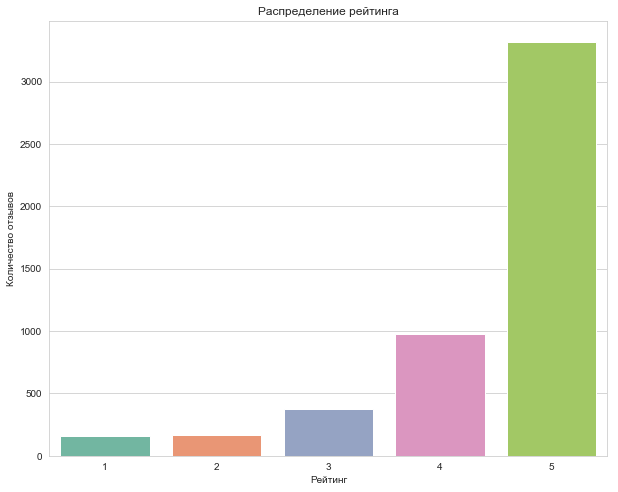

In [31]:
fig = plt.figure(figsize=(10, 8))
sns.countplot(x='rating', data=train);
plt.title("Распределение рейтинга");
plt.xlabel("Рейтинг");
plt.ylabel("Количество отзывов");

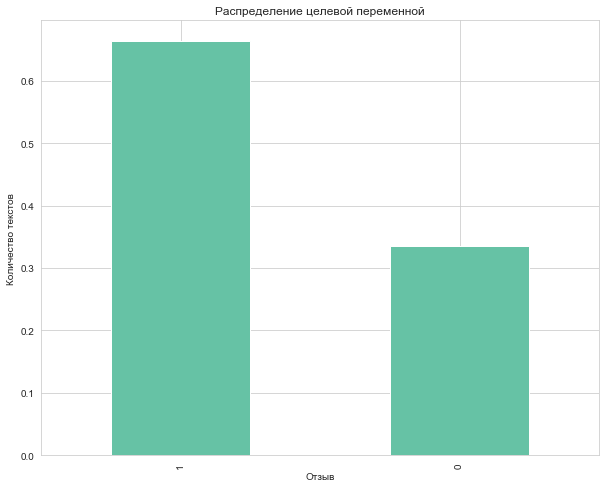

In [32]:
fig = plt.figure(figsize=(10, 8))
train['label'].value_counts(normalize=True).plot(kind='bar');
plt.title("Распределение целевой переменной");
plt.xlabel("Отзыв");
plt.ylabel("Количество текстов");

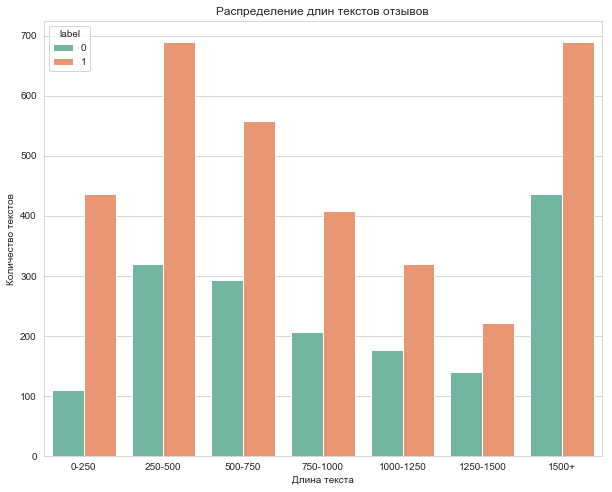

In [33]:
df = train.copy()
df['length'] = pd.cut(train['length'], bins=[0, 250, 500, 750, 1000, 1250, 1500, float('inf')], 
                      labels=['0-250', '250-500', '500-750', '750-1000', '1000-1250', '1250-1500', '1500+'])

fig = plt.figure(figsize=(10, 8))
sns.countplot(x='length', hue='label', data=df);
plt.title("Распределение длин текстов отзывов");
plt.xlabel("Длина текста");
plt.ylabel("Количество текстов");

## 4. Моделирование

Так как целевая переменная не сбалансирована, выберем только 1680 самых развернутых положительных отзывов в обучающую выборку.

In [35]:
train = shuffle(pd.concat([train[train['label'] == 0], 
                           train[train['label'] == 1].sort_values('length', ascending=False).head(1680)]), 
                           random_state=777)

In [36]:
X = train['text'].values
y = train['label'].values

In [37]:
X_test = test['text'].values

In [38]:
stop_words = stopwords.words('russian')

In [39]:
train['label'].value_counts()

1    1680
0    1680
Name: label, dtype: int64

### 4.1. Вспомогательные функции

In [40]:
def make_pipeline(vectorizer, transformer, classifier):
    return Pipeline([
            ('vectorizer', vectorizer),
            ('transformer', transformer),
            ('classifier', classifier)
        ])

In [41]:
def make_estimator(classifier, params_grid, scorer, data, labels):
    pipeline = make_pipeline(CountVectorizer(), TfidfTransformer(), classifier)
    grid_cv = RandomizedSearchCV(pipeline, params_grid, scoring=scorer, cv=5, 
                                 random_state=777, n_iter=100, verbose=1, n_jobs=-1)
    grid_cv.fit(data, labels)
    return grid_cv

### 4.2. Базовая модель

In [42]:
score = cross_val_score(make_pipeline(CountVectorizer(), TfidfTransformer(), LinearSVC(random_state=777)), X, y, cv=5).mean()
print(f"LinearSVC - {score}")

LinearSVC - 0.9336309523809524


### 4.3. Настройка параметров

In [43]:
params_grid_vectorizer = {
    'vectorizer__max_df': [0.85, 0.9, 0.95, 1.0],
    'vectorizer__min_df': [1, 10, 20],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)],
    'vectorizer__stop_words': [stop_words, None]
}
params_grid_transformer = {
    'transformer__norm': ['l1', 'l2'],
    'transformer__smooth_idf': [True, False],
    'transformer__use_idf': [True, False],
    'transformer__sublinear_tf': [True, False]
}
params_grid_lsvc = {
    'classifier__loss': ['hinge', 'squared_hinge'],
    'classifier__max_iter': np.arange(200, 1000, 200),
    'classifier__tol': [1e-5, 1e-4, 1e-3],
    'classifier__C': [0.9, 1.0, 1.1, 1.2]
}

In [45]:
%%time
grid_search_lsvc = make_estimator(LinearSVC(random_state=777), 
                                  {**params_grid_vectorizer, **params_grid_transformer, **params_grid_lsvc}, 'accuracy', X, y)
print("LinearSVC:")
print(f"Лучшее качество - {grid_search_lsvc.best_score_}")
print(f"Параметры - {grid_search_lsvc.best_params_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.5min finished


LinearSVC:
Лучшее качество - 0.9279761904761905
Параметры - {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 10, 'vectorizer__max_df': 0.85, 'transformer__use_idf': True, 'transformer__sublinear_tf': True, 'transformer__smooth_idf': True, 'transformer__norm': 'l2', 'classifier__tol': 0.0001, 'classifier__max_iter': 200, 'classifier__loss': 'hinge', 'classifier__C': 0.9}
CPU times: user 2.61 s, sys: 275 ms, total: 2.88 s
Wall time: 2min 28s


## 5. Предсказание

In [44]:
make_pipeline(CountVectorizer(), TfidfTransformer(), LinearSVC(random_state=777)).fit(X, y).predict(X_test)

array([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0])

In [46]:
svc = grid_search_lsvc.best_estimator_
svc.steps

[('vectorizer',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=0.85, max_features=None, min_df=10,
          ngram_range=(1, 2), preprocessor=None, stop_words=None,
          strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
          tokenizer=None, vocabulary=None)),
 ('transformer',
  TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=True, use_idf=True)),
 ('classifier',
  LinearSVC(C=0.9, class_weight=None, dual=True, fit_intercept=True,
       intercept_scaling=1, loss='hinge', max_iter=200, multi_class='ovr',
       penalty='l2', random_state=777, tol=0.0001, verbose=0))]

In [47]:
pred = svc.predict(X_test)
pred

array([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0])

In [48]:
with open('submission.csv', 'w') as f:
    f.write(pd.DataFrame(pd.Series(map(str, range(0, 100))).str \
                         .cat(map(str, pd.Series(pred).apply(lambda x: 'neg' if x == 0 else 'pos')), sep=','), 
                         columns=['Id,y']).to_csv(sep=' ', index=False))